In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap,ListedColormap

import numpy as np # for array processing
import pandas as pd 

from scipy.stats import norm
from scipy import stats
from scipy.stats import gaussian_kde

import datetime

#import folium
from IPython.display import HTML
from IPython.display import IFrame
import base64
import os
#from matplotlib.cbook import dedent
#C:\Users\bmaillou\AppData\Local\Continuum\anaconda3\Library\share

#### ON PC USE THIS ONE
#os.environ['PROJ_LIB']=u'C:/Users/bmaillou/AppData/Local/Continuum/anaconda3/Library/share'

from mpl_toolkits.basemap import Basemap
#ta\Local\Continuum\anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share
#from mpld3 import save_html  #Installed from conda
#from folium import IFrame

In [2]:
from platform import python_version
#mport statsmodels.api as sm
#rint(sm.version())
print(python_version())
print(pd.__version__)

3.8.5
1.1.3


This only works on a PC where I can still use basemap.  So I output the file I need from the previous script and then use it to make the maps.

## Making the Maps and ACS Vulnerability Data
The last script outputs just the data we need

In [3]:
df_adj=pd.read_excel('DataFiles/fitted_growth_rate.xlsx')

In [4]:
df_adj.describe()

,Unnamed: 0,postcode,growth_rate,fitted,resid,ACS_Vulnerability,tree_dbh_05_copy
count,126362.000000,126362.000000,126362.000000,126056.000000,1.260560e+05,126074.000000,126362.000000
mean,63180.500000,10987.377257,0.275303,0.275282,7.643389e-16,0.517898,13.861390
std,36477.711695,488.810164,0.233739,0.114018,2.040884e-01,0.269534,8.530848
min,0.000000,10001.000000,-0.500000,-0.405127,-6.753848e-01,0.002300,1.000000
25%,31590.250000,10461.000000,0.100000,0.187288,-1.363501e-01,0.298000,7.000000
50%,63180.500000,11220.000000,0.300000,0.284413,-1.309586e-02,0.540700,12.000000
75%,94770.750000,11368.000000,0.400000,0.364376,1.272179e-01,0.743200,20.000000
max,126361.000000,11694.000000,1.600000,0.608130,1.291552e+00,1.000000,40.000000


To check for correct file the rmse of model is 0.20408759206065039

In [5]:
# calc rmse
rmse_model = ((df_adj['resid']) ** 2).mean() ** .5
print('rmse of model is {}'.format(rmse_model))

rmse of model is 0.2040875920606504


## Group everything we need for mapping and plotting by zipcode
* Print
* fix column names to one level
* print 20 zip codes with fewest trees
* read in zip code areas.  
* concat zip code areas.  convert to km2.
* drop missing zips


In [6]:
df_zip=df_adj.groupby('postcode').agg({'growth_rate':['count','mean']
                                       ,'resid':'mean'
                                       ,'ACS_Vulnerability':'mean'
                                      ,'tree_dbh_05_copy':'mean'})
df_zip.columns = [' '.join(col).strip() for col in df_zip.columns.values]

## Get zip code area
df_zip_area=pd.read_excel('shapefiles/zipcode_area.xlsx')
df_zip_area.rename(columns = {'ZIPCODE':'postcode'}, inplace = True)
df_zip_area.set_index('postcode',inplace=True)
df_zip_area.sort_index(inplace=True)
df_zip_area=df_zip_area['Area_m2'].to_frame()
df_zip_area['Area_m2']=df_zip_area['Area_m2']/1000/1000
df_zip_area=df_zip_area.groupby(df_zip_area.index).sum()

df_zip=pd.concat([df_zip,df_zip_area],axis=1).dropna()
df_zip['trees_km2']=df_zip['growth_rate count']/df_zip['Area_m2']
###############################


In [7]:
df_zip.describe()


,growth_rate count,growth_rate mean,resid mean,ACS_Vulnerability mean,tree_dbh_05_copy mean,Area_m2,trees_km2
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,717.965909,0.271571,-0.002522,0.573454,12.299523,4.215819,185.283868
std,686.632486,0.055872,0.046762,0.239329,3.838105,4.360222,113.915431
min,1.000000,0.000000,-0.227033,0.077373,4.000000,0.064782,1.588108
25%,292.500000,0.243400,-0.023227,0.388735,8.562872,1.877371,101.456154
50%,559.000000,0.277942,-0.000238,0.554226,12.724652,3.586734,173.376717
75%,992.750000,0.303220,0.019401,0.789775,15.264896,5.393702,259.387661
max,4986.000000,0.402778,0.237598,0.981497,21.494624,44.034492,661.829755


## Figure 4

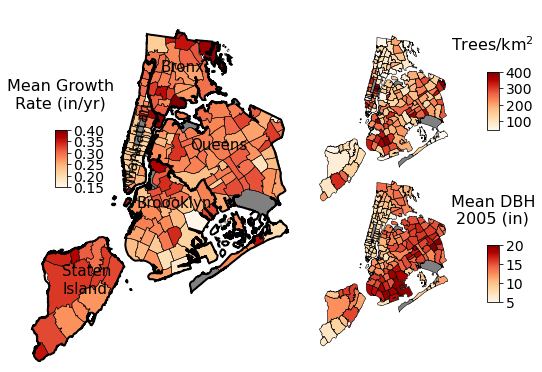

In [8]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(8,8)

gs = ax[0, 0].get_gridspec()
ax[0,0].remove()
ax[0,1].remove()
ax[1,0].remove()
ax[1,1].remove()
axbig = fig.add_subplot(gs[:, 0:2])

### Do a loop to make the three maps   
for i in np.arange(3):
    df_temp=pd.DataFrame()
    if i==0:
        vmin=50
        vmax=400
        df_temp['scaled']=(df_zip['trees_km2']-vmin)/(vmax-vmin)
        df_temp.dropna(subset=['scaled'],inplace=True)
        cbar_title='Trees/km$^2$\n'
        cmap=plt.cm.OrRd
        axtemp=ax[0,2]
    if i==1:
        vmin=5
        vmax=20
        df_temp['scaled']=(df_zip['tree_dbh_05_copy mean']-vmin)/(vmax-vmin)
        cbar_title='Mean DBH\n2005 (in)\n'
        cmap=plt.cm.OrRd
        axtemp=ax[1,2]
    if i==2:
        vmin=0.15
        vmax=0.4
        df_temp['scaled']=(df_zip['growth_rate mean']-vmin)/(vmax-vmin)
        cbar_title='Mean Growth\nRate (in/yr)\n'
        cmap=plt.cm.OrRd
        axtemp=axbig

    m = Basemap(llcrnrlon=-74.3,llcrnrlat=40.5,urcrnrlon=-73.6,urcrnrlat=40.9,projection='lcc',\
            lat_1=33,lat_2=45,lon_0=-95,ax=axtemp)
    shp_info = m.readshapefile('shapefiles/mygeodata/ZIP_CODE_040114','zip')#,drawbounds=True)

    for count,shape_dict in enumerate(m.zip_info):
        if int(shape_dict['ZIPCODE']) in df_temp.index:
            color=rgb2hex(cmap(df_temp['scaled'][int(shape_dict['ZIPCODE'])].item()))
        else:
            color='gray'
    #        
        seg = m.zip[count]
        poly = Polygon(seg, facecolor=color,edgecolor='gray',lw=.15)
        axtemp.add_patch(poly)

    #################################################### Try to add bouroughs.  a test
    if i==2:
        shp_info = m.readshapefile('shapefiles/BoroughBoundaries/geo_export_8ed020ab-b01b-4307-bd49-cc47c46d9669','zip')#,drawbounds=True)
        for count,shape_dict in enumerate(m.zip_info):

            color='gray'
        #        
            seg = m.zip[count]
            poly = Polygon(seg, facecolor='none',edgecolor='black',lw=2.0,zorder=10)
            axtemp.add_patch(poly)
        #axtemp.text(.39,.6,'M',transform=axtemp.transAxes,horizontalalignment='left',fontsize=20,zorder=10,color='green')
        axtemp.text(.37,.52,'Manhattan',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10,rotation=78)
        axtemp.text(.50,.82,'Bronx',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        axtemp.text(.6,.6,'Queens',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        axtemp.text(.42,.44,'Broooklyn',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        axtemp.text(.17,.2,'Staten\nIsland',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
    
    ##########################################
        
        
    norm = Normalize(vmin=vmin, vmax=vmax)
    if i==0:
        cax = fig.add_axes([0.95, 0.6, 0.02, 0.1])
    if i==1:
        cax = fig.add_axes([0.95, 0.3, 0.02, 0.1])
    if i==2:
        cax = fig.add_axes([0.2, 0.5, 0.02, 0.1]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='vertical')
    cb.ax.set_xlabel(cbar_title,fontsize=16)   
    cb.ax.tick_params(labelsize=14,which='major')
    cb.ax.xaxis.set_label_position('top')
    cb.ax.locator_params(nbins=5)
    axtemp.axis('off')
    #sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    #cb = fig.colorbar(sm,ax=ax[i], orientation='horizontal')
filename='Figures/Figure4-all_trees'+'_3PartMap_different_size.jpg'

fig.subplots_adjust(wspace=0,hspace=-.50)
fig.savefig(filename,dpi=1000,bbox_inches='tight') 
        #fig.close('all')
# save it
#filename='{}stdGrowth.jpg'.format(tree)
#fig.savefig(filename,dpi=600) 

## Figure 8

## Remove unwanted zip codes
* save unwanted to a seperate dataframe
* remove zips with less than 100
* remove coney island and rockaway outliers.  These were flooded and tree growth was whacky
* then make map and correlation

In [9]:
df_zip['growth_rate count'].sort_values().head(20)

postcode
10006      1.0
11005      2.0
10004      2.0
10005      5.0
10007      6.0
10020      9.0
10280     12.0
11239     13.0
10038     20.0
10039     29.0
11693     38.0
11692     41.0
10018     45.0
10037     47.0
10451     58.0
10474     72.0
10013     85.0
10034     87.0
10017     93.0
10454    100.0
Name: growth_rate count, dtype: float64

In [10]:
## zip codes with less than 100
df_drop_small=df_zip.loc[[10006,11005,10004,10005,10007,10020,10280\
                      ,11239,10038,10039,11693,11692,10018,10037\
                      ,10451,10474,10013,10034,10017]]

df_zip.drop([10006,11005,10004,10005,10007,10020,10280\
                      ,11239,10038,10039,11693,11692,10018,10037\
                      ,10451,10474,10013,10034,10017],inplace=True)

# postcodes down coney island and rockaway
df_drop_flood=df_zip.loc[[11224,11691]]
df_zip.drop([11224,11691],inplace=True)

0
1
i=1
2


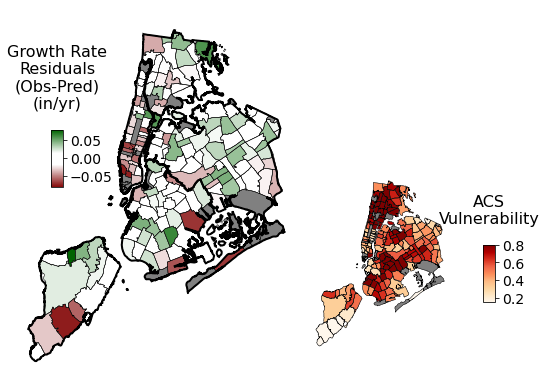

In [11]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(8,8)

gs = ax[0, 0].get_gridspec()
ax[0,0].remove()
ax[0,1].remove()
ax[1,0].remove()
ax[1,1].remove()
ax[0,2].remove()
axbig = fig.add_subplot(gs[:, 0:2])


## Get zip code area
df_zip_area=pd.read_excel('shapefiles/zipcode_area.xlsx')
df_zip_area.rename(columns = {'ZIPCODE':'postcode'}, inplace = True)
df_zip_area.set_index('postcode',inplace=True)
df_zip_area.sort_index(inplace=True)
df_zip_area=df_zip_area['Area_m2'].to_frame()
df_zip_area['Area_m2']=df_zip_area['Area_m2']/1000/1000
df_zip_area=df_zip_area.groupby(df_zip_area.index).sum()
#color map


#tree name
#tree='ginko'
#for tree,df in g:
#    print(tree)
    #scaling

    
for i in np.arange(3):
    print(i)
    if i==10:  #### TOTAL 2015 TREES/KM2
        #These lines do trees from the database
        #vmin=250
        #vmax=2000
        #df_temp=df_2015.groupby('postcode')['tree_dbh'].count().to_frame()
        #df_temp=pd.concat([df_temp,df_zip_area],axis=1)

        #df_temp_zip=df_temp        
        #df_temp['scaled']=(df_temp['tree_dbh']/df_temp['Area_m2']-vmin)/(vmax-vmin)
        
        vmin=2
        vmax=12
        #df_temp=df_Tree_Cov.groupby('postcode')['tree_canopy_percentage'].mean().to_frame()
        #df_temp=pd.concat([df_temp,df_zip_area],axis=1)

        #df_temp_zip=df_temp
        df_temp['scaled']=(df_temp['tree_canopy_percentage']-vmin)/(vmax-vmin)
        df_temp.dropna(subset=['scaled'],inplace=True)
        cbar_title='Percent Canopy\nCoverage\n'
        cmap=plt.cm.OrRd
        axtemp=ax[0,2]
        #print(df_temp['growth_rate'].sum())
        df_temp0=df_temp

    if i==1:   ##### ACS
        #df['R_PL_THEMES']=df['R_PL_THEMES'].mask(df['R_PL_THEMES']<0,np.nan)

        vmin=0.15
        vmax=0.8
        #df_temp=df_adj.groupby('postcode')['ACS_Vulnerability'].mean().to_frame()
        df_temp['scaled']=(df_zip['ACS_Vulnerability mean']-vmin)/(vmax-vmin)
        cbar_title='ACS\nVulnerability\n'
        cmap=plt.cm.OrRd
        axtemp=ax[1,2]
        df_temp1=df_temp
        print('i=1')
    if i==2:  ##### ADJUSTED DATA
        vmin=-.08
        vmax=.08
        #df_temp=df_adj.groupby('postcode')['resid'].mean().to_frame()
        #print(df_temp.fitted.mean())
        df_temp['scaled']=(df_zip['resid mean']-vmin)/(vmax-vmin)
        cbar_title='Growth Rate\nResiduals\n(Obs-Pred)\n(in/yr)\n'
        #cmap = ListedColormap(["maroon","orangered", "coral","white", "white","palegreen","forestgreen","darkgreen"])
        #cmap=cmap#plt.cm.PiYG#RdBu_r#OrRd
        cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'maroon'),
                                              (0.4, 'white'),
                                              (0.6,'white'),
                                              (1,    'darkgreen')], N=256)
        #cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        axtemp=axbig
        df_temp2=df_temp

    m = Basemap(llcrnrlon=-74.3,llcrnrlat=40.5,urcrnrlon=-73.6,urcrnrlat=40.9,projection='lcc',\
            lat_1=33,lat_2=45,lon_0=-95,ax=axtemp)
    shp_info = m.readshapefile('shapefiles/mygeodata/ZIP_CODE_040114','zip')#,drawbounds=True)

    for count,shape_dict in enumerate(m.zip_info):
        #print (shape_dict['ZCTA5CE10'])
        #
        color='pink'
        if int(shape_dict['ZIPCODE']) in df_zip.index:
            #print(shape_dict['ZCTA5CE10'])
            #print(df[tree][int(shape_dict['ZCTA5CE10'])])
            #print(count,shape_dict,color,df_temp['scaled'][int(shape_dict['ZIPCODE'])])
            color=rgb2hex(cmap(df_temp['scaled'][int(shape_dict['ZIPCODE'])].item()))
        else:
            color='grey'
    #        
        seg = m.zip[count]
        poly = Polygon(seg, facecolor=color,edgecolor='gray',lw=.15)
        axtemp.add_patch(poly)


    norm = Normalize(vmin=vmin, vmax=vmax)
    if i==10:
        cax = fig.add_axes([0.95, 0.6, 0.02, 0.1])
    if i==1:
        cax = fig.add_axes([0.95, 0.3, 0.02, 0.1])
    if i==2:
        cax = fig.add_axes([0.2, 0.5, 0.02, 0.1]) # posititon
    if i>0:    
        cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='vertical')
        cb.ax.set_xlabel(cbar_title,fontsize=16)   
        cb.ax.tick_params(labelsize=14,which='major')
        cb.ax.xaxis.set_label_position('top')
        cb.ax.locator_params(nbins=5)
        axtemp.axis('off')
    #sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    #cb = fig.colorbar(sm,ax=ax[i], orientation='horizontal')
    
    #################################################### Try to add bouroughs.  a test
    if i==2:
        shp_info = m.readshapefile('shapefiles/BoroughBoundaries/geo_export_8ed020ab-b01b-4307-bd49-cc47c46d9669','zip')#,drawbounds=True)
        for count,shape_dict in enumerate(m.zip_info):

            color='gray'
        #        
            seg = m.zip[count]
            poly = Polygon(seg, facecolor='none',edgecolor='black',lw=2.0,zorder=10)
            axtemp.add_patch(poly)
        #axtemp.text(.39,.6,'M',transform=axtemp.transAxes,horizontalalignment='left',fontsize=20,zorder=10,color='green')
        #axtemp.text(.37,.52,'Manhattan',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10,rotation=78)
        #axtemp.text(.50,.82,'Bronx',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        #axtemp.text(.6,.6,'Queens',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        #axtemp.text(.42,.44,'Broooklyn',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        #axtemp.text(.17,.2,'Staten\nIsland',transform=axtemp.transAxes,horizontalalignment='left',fontsize=15,zorder=10)
        
filename='Figures/Figure8-residuals-ACS.jpg'

fig.subplots_adjust(wspace=0,hspace=-.50)
fig.savefig(filename,dpi=1000,bbox_inches='tight') 
        #fig.close('all')
# save it
#filename='{}stdGrowth.jpg'.format(tree)
#fig.savefig(filename,dpi=600)   

## Figure 9

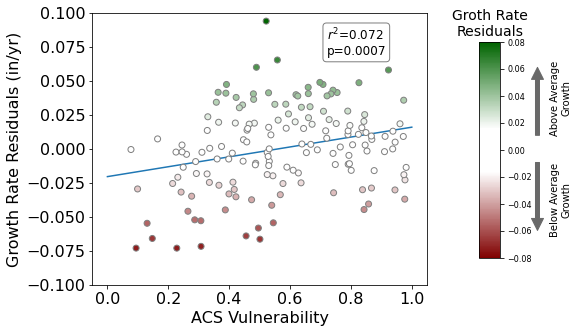

In [14]:
props=dict(boxstyle='round',facecolor='white',alpha=0.5)

cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'maroon'),
                                              (0.4, 'white'),
                                              (0.6,'white'),
                                              (1,    'darkgreen')], N=256)
fig,ax=plt.subplots()
fig.set_size_inches(6,5)


# https://stackoverflow.com/questions/26558816/matplotlib-scatter-plot-with-legend

##########################################################################################
cax=ax.scatter(df_zip['ACS_Vulnerability mean']
               ,df_zip['resid mean']\
               ,c=df_zip['resid mean']\
               ,vmin=-.08,vmax=.08,cmap=cmap,edgecolor='gray',zorder=200000)
#ax.scatter(df_drop_small['ACS_Vulnerability mean'],df_drop_small['resid mean'])
#ax.scatter(df_drop_flood['ACS_Vulnerability mean'],df_drop_flood['resid mean'])


results=stats.linregress(df_zip[['ACS_Vulnerability mean','resid mean']].dropna())
textstr='$r^2$={:.3f}\np={:.4f}'.format(results.rvalue**2,results.pvalue)

x=np.array([0,1])

ax.plot(x,results.slope*x+results.intercept,zorder=30)

ax.text(0.7,0.95,textstr,transform=ax.transAxes,fontsize=12\
    ,verticalalignment='top',bbox=props,zorder=150)

ax.set_xlabel('ACS Vulnerability',fontsize=16)
ax.set_ylabel('Growth Rate Residuals (in/yr)',fontsize=16)
ax.tick_params(axis='x', labelsize= 16)
ax.tick_params(axis='y', labelsize= 16)


#ax[1].axhline(y=0,c='k',lw='.5',zorder=10,linestyle='-.')

ax.annotate('', xy=(1.33,.8), xycoords='axes fraction', xytext=(1.33, .55), 
            arrowprops=dict(color='dimgrey',width=4))
ax.text(1.4,.55, 'Above Average\nGrowth',rotation=90,transform=ax.transAxes
           ,horizontalalignment='center',verticalalignment='bottom')

ax.annotate('', xy=(1.33,.2), xycoords='axes fraction', xytext=(1.33, .45), 
            arrowprops=dict(color='dimgrey',width=4))
ax.text(1.4,.45, 'Below Average\nGrowth',rotation=90,transform=ax.transAxes
           ,horizontalalignment='center',verticalalignment='top')

ax.set_ylim(-.1,.1)

position=fig.add_axes([1.02,0.2,0.05,0.6])  ## the parameters are the specified position you set 

#fig1.colorbar(sc,cax=position)

clb=fig.colorbar(cax,cax=position, fraction=0.025, pad=0.1)
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Groth Rate\nResiduals',fontsize=14)

#ax.hlines(y=0.08,xmin=0,xmax=1)


fig.savefig('Figures/Figure9-Vulnerability_vs_Coverage_Residuals_all_boroughs.jpg',dpi=1000,bbox_inches='tight')

Just in case we want it it is residual versus vulnerability tree by tree.  lower r but significant b/c so much data

In [13]:
stats.linregress(df_adj[['resid','ACS_Vulnerability']].dropna())

LinregressResult(slope=0.05753937343745475, intercept=0.5179264592176229, rvalue=0.043581078719472845, pvalue=6.165899647698955e-54, stderr=0.003719324522518035)

# END